# TMD 2024
### Lucas Poma
## Trabajo Practico 2

## Imports

In [1]:
library(ggplot2)
library(rpart)
library(class)
library(MASS)
install.packages("caret")
library(caret)
install.packages("randomForest")
library(randomForest)
install.packages("kernlab")
library(kernlab)
install.packages("gridExtra")
library(gridExtra)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: lattice

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘gridExtra’



## Estimadores Error

In [71]:
#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
  invisible(capture.output(model <- ksvm(as.matrix(x.train), as.factor(y), type=type,kernel=kernel,C=C,cross = cross)))
  return ( model@cross )
}


#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))

	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
  num.feat<-dim(x.train)[2]
  tot.problems<-nlevels(y)*(nlevels(y)-1)/2

  invisible(capture.output(m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)))

  w<-rep(0.0,num.feat)
  for(i in 1:tot.problems) for(feat in 1:num.feat)
      w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
  rank.list<-sort(w,decreasing=FALSE,index=T)
  return(list(feats=rank.list$ix,imp=rank.list$x))
}

## Diagonales

In [72]:
diagonales <- function(n, d, C) {
  half <- floor(n / 2)

  mClass0 <- rep(-1, d)
  mClass1 <- rep(1, d)
  covM <- diag(C^2 * d, d)

  class0 <- MASS::mvrnorm(n = half, mu = mClass0, Sigma = covM)
  class1 <- MASS::mvrnorm(n = n - half, mu = mClass1, Sigma = covM)

  labels0 <- matrix(0, nrow = half, ncol = 1)
  labels1 <- matrix(1, nrow = n - half, ncol = 1)

  data0 <- cbind(class0, labels0)
  data1 <- cbind(class1, labels1)

  data <- rbind(data0, data1)

  columns <- c(paste0("dim_", 1:d), "class")
  dataFrame <- as.data.frame(data)
  colnames(dataFrame) <- columns
  dataFrame$class <- as.factor(dataFrame$class)

  return(dataFrame)
}


## Ejercicio 1

In [73]:
forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]		#total de features
	num.feat<-1				#numero actual de features
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	#ranking inicial: elijo la variable con menor error de prediccion
	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train<-x[,i,drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	#guardo la variable con minimo error como primera en mi lista de elegidas. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego a la lista del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
		    features<-c(list.feat[1:num.feat],keep.feat[i])
			x.train<-x[,features]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1 #proximo paso
	}

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",list.feat,"\n")
	}

 	return(list.feat)

}

In [74]:
backward.ranking <- function(x, y, method, verbosity = 0, ...) {

  max.feat <- dim(x)[2]    # Total number of features
  list.feat <- 1:max.feat  # Initialize the list of features
  keep.feat <- double(max.feat)  # Store the order of eliminated features

  # Main loop: Keep removing the least important feature until only one is left
  while(length(list.feat) > 1){

    # Initialize a vector to store the error for each model (one per feature)
    class.error <- double(length(list.feat))

    # Train models by removing one feature at a time and compute error
    for(i in 1:length(list.feat)){
      x.train <- as.matrix(x[, list.feat[-i]])
      class.error[i] <- do.call(method, c(list(x.train, y), list(...)))
    }

    # Find the feature whose removal results in the smallest increase in error
    worst.feat <- which.min(class.error)

    # Store this feature as the next to be removed
    keep.feat[length(list.feat)] <- list.feat[worst.feat]

    # Remove this feature from the list of remaining features
    list.feat <- list.feat[-worst.feat]

    # Verbose output if needed
    if(verbosity > 1) {
      cat("\nStep ", max.feat - length(list.feat), "\nRemoved Feature: ", worst.feat, "\n")
    }
  }

  # The last remaining feature is the most important
  keep.feat[1] <- list.feat

  # Return the final result
  return(keep.feat)
}

In [75]:
kruskal.ranking <- function(x, y, verbosity = 0) {

  max.feat <- dim(x)[2]  # Total number of features
  p.values <- double(max.feat)  # Vector to store p-values

  # Calculate Kruskal-Wallis p-values for each feature
  for (i in 1:max.feat) {
    p.values[i] <- kruskal.test(x[, i], y)$p.value

    # Print verbose output if required
    if (verbosity > 1) {
      cat("Feature", i, "- p-value:", p.values[i], "\n")
    }
  }

  # Rank the features based on their p-values (ascending order)
  list.feat <- order(p.values)

  # Verbose output to print the final ranking
  if (verbosity > 1) {
    cat("\nFinal ranking of features based on Kruskal-Wallis test:\n")
    cat("Features ranked (by index):", list.feat, "\n")
  }

  # Return the ranked features
  return(list.feat)
}

In [76]:
rfe.ranking <- function(x, y, method, verbosity = 0, ...) {

  max.feat <- dim(x)[2]  # Total number of features
  list.feat <- 1:max.feat  # Initialize the list of all features
  rank.list <- double(max.feat)  # To store the ranking of features

  # Main loop: Remove one feature at a time based on the method
  for (i in 1:max.feat) {
    # Train the model using the remaining features
    x.train <- as.matrix(x[, list.feat])

    # Use the specified method to rank the features
    rank_ <- do.call(method, c(list(x.train, y), list(...)))

    # Get the feature with the lowest importance
    last <- rank_$feats[1]

    # Store the removed feature in the rank list
    rank.list[max.feat - i + 1] <- list.feat[last]

    # Remove the least important feature from the list
    list.feat <- list.feat[-last]

    # Verbose output for intermediate steps
    if (verbosity > 1) {
      cat("Step", i, "- Removed feature:", last, "\n")
    }
  }

  # Verbose output to print the final ranking
  if (verbosity > 1) {
    cat("\nFinal ranking of features using RFE:\n")
    cat("Features ranked (by index):", rank.list, "\n")
  }

  # Return the ranked features
  return(rank.list)
}

## DataSets

In [77]:
#---------------------------------------------------------------------------
#Codigo con datasets de ejemplo y para el TP2
#---------------------------------------------------------------------------
#hacer una funcion que cree datos, 2 clases (-1 y 1,n puntos de cada una), d dimensiones, de ruido uniforme [-1,1], con la clase al azar

crea.ruido.unif<-function(n=100,d=2){
x<-runif(2*n*d,min=-1)	#genero los datos
dim(x)<-c(2*n,d)
return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}

#---------------------------------------------------------------------------
#CREA DATASET datosB
#Dataset artificial con orden de importancia: 8-6-4-2
#---------------------------------------------------------------------------
d<-10
n<-1000
datos<-crea.ruido.unif(n=n,d=d)

#tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,d+1]<-sign(datos[sub,8])
#tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
sub<-shuffle[(dim(datos)[1]*0.5):(dim(datos)[1]*0.7)]
datos[sub,d+1]<-sign(datos[sub,6])
#tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
sub<-shuffle[(dim(datos)[1]*0.7):(dim(datos)[1]*0.8)]
datos[sub,d+1]<-sign(datos[sub,4])
#tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
sub<-shuffle[(dim(datos)[1]*0.8):(dim(datos)[1]*0.85)]
datos[sub,d+1]<-sign(datos[sub,2])
datos[,d+1]<-factor(datos[,d+1])

datosA<-datos

#---------------------------------------------------------------------------
#CREA DATASET datosB
#Dataset artificial con dos variables relevantes (1-2) y dos variables que son importantes pero que no resuelven el problema (3-4)
#---------------------------------------------------------------------------
#generar n=100,d=8
d<-8
n<-1000
datos<-crea.ruido.unif(n=n,d=d)
#hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
datos[,d+1]<-sign(datos[,1]*datos[,2])
#hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,3]<-abs(datos[sub,3])*datos[sub,d+1]
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,4]<-abs(datos[sub,4])*datos[sub,d+1]
datos[,d+1]<-factor(datos[,d+1])

datosB<-datos

## Ejercicio 2

### Datos A

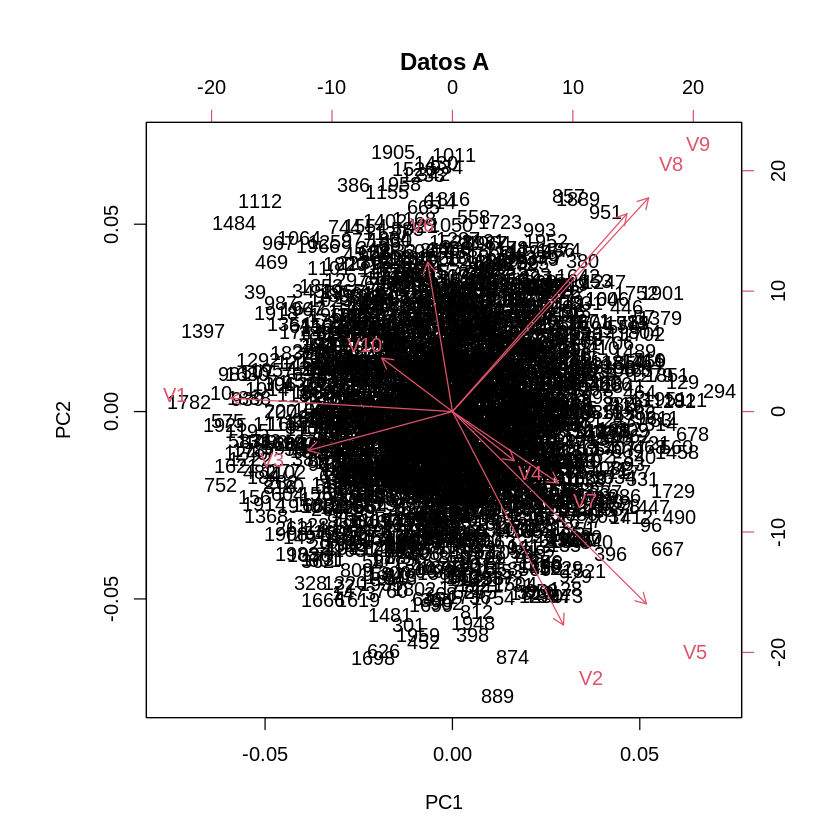

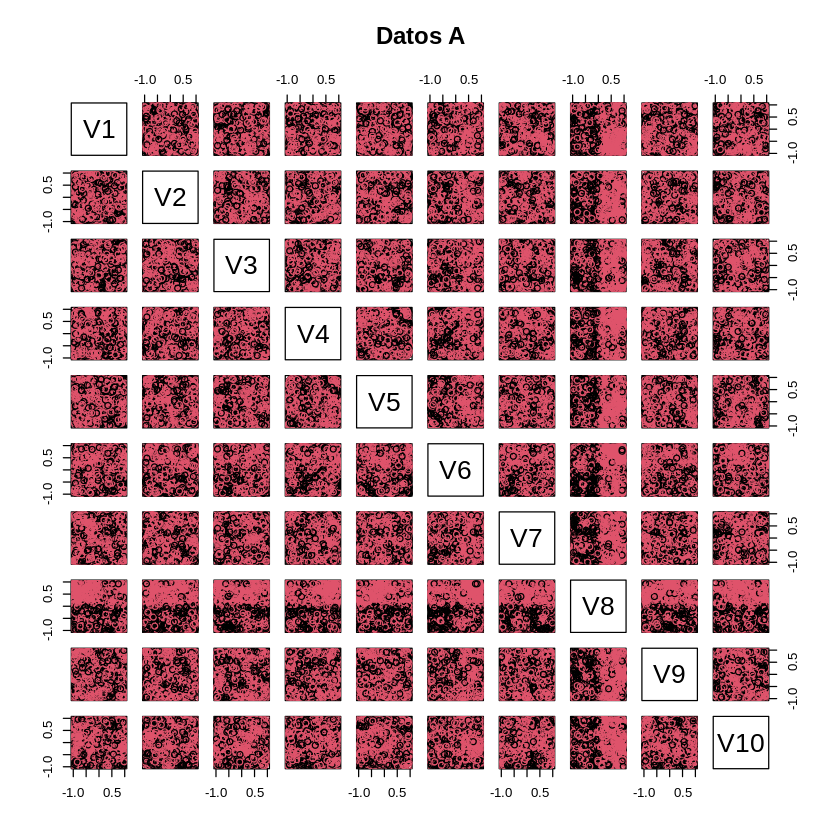

In [91]:
datosA.x = datosA[,1:10]
datosA.y = datosA$y

datosA.pca<-prcomp(datosA.x, scale = T)
biplot(datosA.pca, main= "Datos A")
plot(datosA.x, col=datosA.y, main="Datos A")

#### Forward Ranking

In [92]:
datosA.forward.rf <- forward.ranking(datosA.x, datosA.y, "rf.est")
datosA.forward.lda <- forward.ranking(datosA.x, datosA.y, "lda.est")
datosA.forward.svm <- forward.ranking(datosA.x, datosA.y, method="svm.est")

In [93]:
cat("\n > Forward ranking RF \n")
datosA.forward.rf
cat("\n > Forward ranking LDA \n")
datosA.forward.lda
cat("\n > Forward ranking SVM \n")
datosA.forward.svm


 > Forward ranking RF 


[1]  8  3  9 10  1  7  5  2  4  6


 > Forward ranking LDA 


[1]  8  9  5 10  3  7  2  1  4  6


 > Forward ranking SVM 


[1]  8 10  9  5  3  1  2  4  7  6

#### Backward Ranking

In [94]:
datosA.backward.rf = backward.ranking(datosA.x, datosA.y, "rf.est")
datosA.backward.lda = backward.ranking(datosA.x, datosA.y, "lda.est")
datosA.backward.svm <- backward.ranking(datosA.x, datosA.y, method="svm.est")

In [95]:
cat("\n > Backward ranking RF \n")
datosA.backward.rf
cat("\n > Backward ranking LDA \n")
datosA.backward.lda
cat("\n > Backward ranking SVM \n")
datosA.backward.svm


 > Backward ranking RF 


[1]  8 10  2  7  3  9  5  4  1  6


 > Backward ranking LDA 


[1]  8 10  3  2  1  5  9  7  4  6


 > Backward ranking SVM 


[1]  8  9  7  3 10  4  5  2  1  6

#### Kruskall Wallice Ranking

In [96]:
datosA.kruskal = kruskal.ranking(datosA.x, datosA.y)

In [97]:
cat("\n > Kruskal ranking \n")
datosA.kruskal


 > Kruskal ranking 


[1]  8  6  4  1  2  3  9  7 10  5

#### RFE Ranking

In [98]:
datosA.rfe.rf = rfe.ranking(datosA.x, datosA.y, "imp.rf")
datosA.rfe.linsvm <- rfe.ranking(datosA.x, datosA.y, method="imp.linsvm")

In [99]:
cat("\n > RFE ranking RF \n")
datosA.rfe.rf
cat("\n > RFE ranking LINSVM \n")
datosA.rfe.linsvm


 > RFE ranking RF 


[1]  8  6  4  2  9 10  5  7  1  3


 > RFE ranking LINSVM 


[1]  8  6  4  2  3  7  5  1  9 10

### Datos B

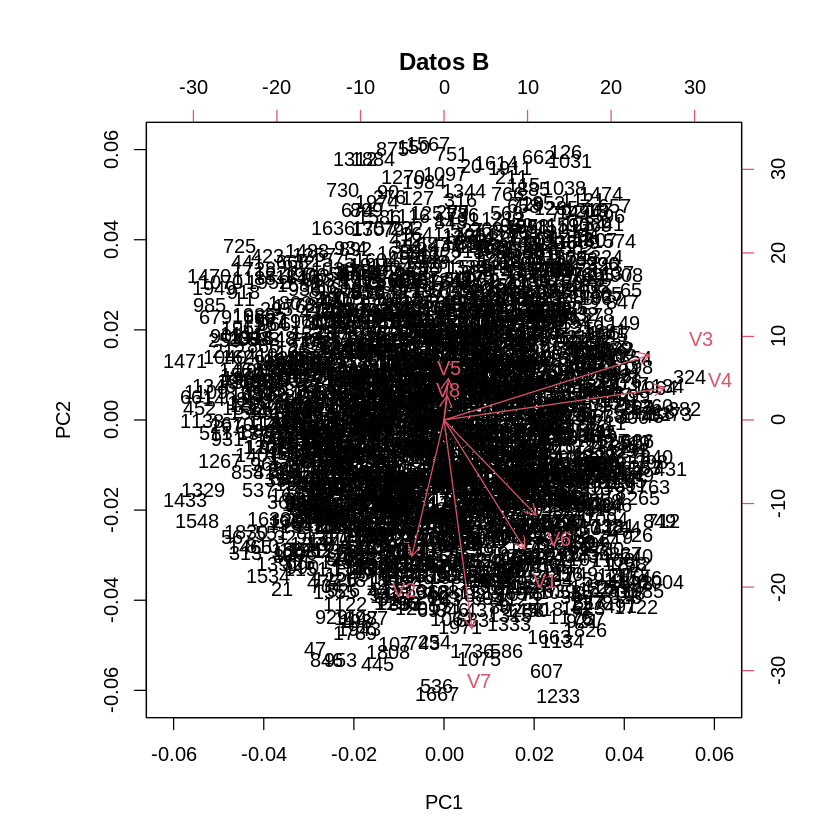

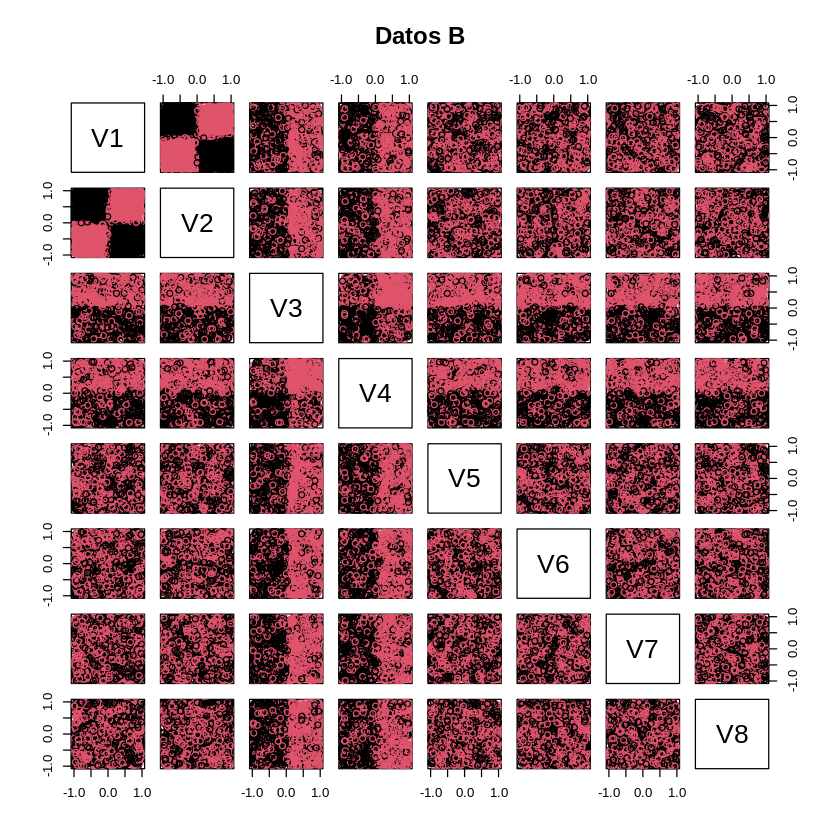

In [ ]:
datosB.x = datosB[,1:8]
datosB.y = datosB$y

datosB.pca<-prcomp(datosB.x, scale = T)
biplot(datosB.pca, main= "Datos B")
plot(datosB.x, col=datosB.y, main="Datos B")

#### Forward Ranking

In [ ]:
datosB.forward.rf <- forward.ranking(datosB.x, datosB.y, "rf.est")
datosB.forward.lda <- forward.ranking(datosB.x, datosB.y, "lda.est")
datosB.forward.svm <- forward.ranking(datosB.x, datosB.y, method="svm.est")

In [ ]:
cat("\n > Forward ranking RF \n")
datosB.forward.rf
cat("\n > Forward ranking LDA \n")
datosB.forward.lda
cat("\n > Forward ranking SVM \n")
datosB.forward.svm


 > Forward ranking RF 


[1]  8 10  2  7  9  3  5  1  4  6


 > Forward ranking LDA 


[1]  8  9  5 10  3  7  2  1  4  6


 > Forward ranking SVM 


[1]  8  5 10  9  3  2  1  7  4  6

#### Backward Ranking

In [ ]:
datosB.backward.rf = backward.ranking(datosB.x, datosB.y, "rf.est")
datosB.backward.lda = backward.ranking(datosB.x, datosB.y, "lda.est")
datosB.backward.svm <- backward.ranking(datosB.x, datosB.y, method="svm.est")

In [ ]:
cat("\n > Backward ranking RF \n")
datosB.backward.rf
cat("\n > Backward ranking LDA \n")
datosB.backward.lda
cat("\n > Backward ranking SVM \n")
datosB.backward.svm


 > Backward ranking RF 


[1]  8 10  2  7  9  1  3  5  4  6


 > Backward ranking LDA 


[1]  8 10  3  2  1  5  9  7  4  6


 > Backward ranking SVM 


[1]  8  7 10  5  1  2  9  3  4  6

#### Kruskall Wallice Ranking

In [ ]:
datosB.kruskal = kruskal.ranking(datosB.x, datosB.y)

In [ ]:
cat("\n > Kruskal ranking \n")
datosB.kruskal


 > Kruskal ranking 


[1]  8  6  4  1  2  3  9  7 10  5

#### RFE Ranking

In [ ]:
datosB.rfe.rf = rfe.ranking(datosB.x, datosB.y, "imp.rf")
datosB.rfe.linsvm <- rfe.ranking(datosB.x, datosB.y, method="imp.linsvm")

In [ ]:
cat("\n > RFE ranking RF \n")
datosB.rfe.rf
cat("\n > RFE ranking LINSVM \n")
datosB.rfe.linsvm


 > RFE ranking RF 


[1]  8  6  4 10  3  2  5  9  7  1


 > RFE ranking LINSVM 


[1]  8  6  4  2  3  7  5  1  9 10

## Ejercicio 3